## Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load summary metrics file
summary_df = pd.read_csv('../data/derived/performance/summary.csv')

# preview dataframe
summary_df.sample(5)

,model_name,dataset_name,vector_name,hyperparameter_name,hyperparameter_value,metric_name,metric_value
1068,svc,train,count,c,10,accuracy,1.000000
1988,decisiontree,dev,tfidf,maxdepth,None,true_positives,466.000000
173,mlp,dev,lsi100,alpha,0.01,macro_recall,0.857147
287,mlp,dev,count,alpha,0.0001,macro_f1,0.892434
1850,decisiontree,dev,lsi5,maxdepth,None,true_negatives,588.000000


## Visualize performance with line plots

In [3]:
def visualize_model_metric(summary_df, metric_name, model_name):
    """
    Print line graph of training and development performance for provided metric and model
    """
    
    # copy summary dataframe
    df = summary_df.copy()
    
    # filter dataframe to provided metric
    df = df[df['metric_name'] == metric_name]
    
    # get y-limit to use regardless of model type
    y_lim = (min(df['metric_value']), max(df['metric_value'])+0.01)
    
    # filter dataframe to provided model
    df = df[df['model_name']  == model_name]
    
    # reset indices
    df.reset_index(inplace=True, drop=True)
        
    # get hyperparameter name (assumes only one hyperparameter name per model)
    hyperparameter_name = df['hyperparameter_name'].unique()[0]
    
    # sort dataframe by vector name
    df.sort_values(by='vector_name', inplace=True)
    
    # sort dataframe by ascending hyperparameter value
    sorted_idx = np.argsort([float(x) if x.replace('.','',1).isnumeric() else float('inf') for x in df['hyperparameter_value']])
    df = df.iloc[sorted_idx, :]
    
    # set plot style
    sns.set_style("whitegrid")
    
    # plot decision tree performance
    g = sns.relplot(data = df,
                    x = 'hyperparameter_value',
                    y = 'metric_value',
                    hue = 'dataset_name', 
                    row = 'vector_name',
                    row_order = ['count','tfidf','lsi5','lsi10','lsi50','lsi100'],
                    kind = 'line',
                    height = 2.25,
                    aspect = 2)
    
    # adjust y-axis limit
    g.set(ylim=y_lim)
    
    # write figure to visualizations file
    g.savefig(f'../data/derived/visualizations/{model_name}_{metric_name}.png')
    
    return g

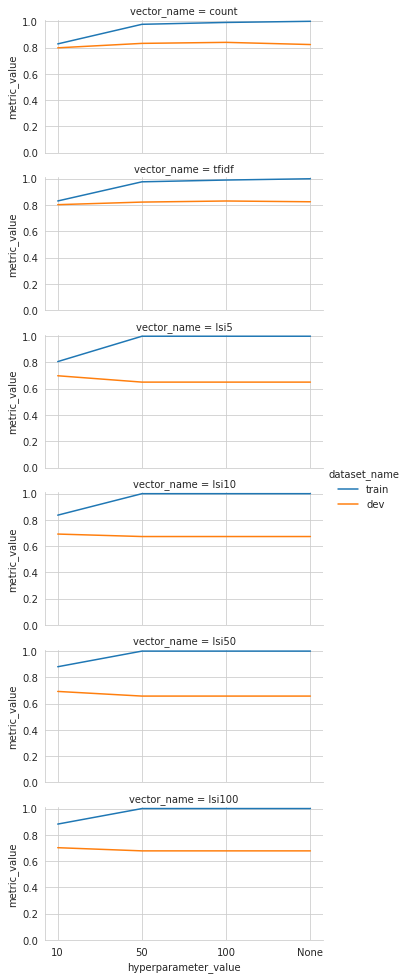

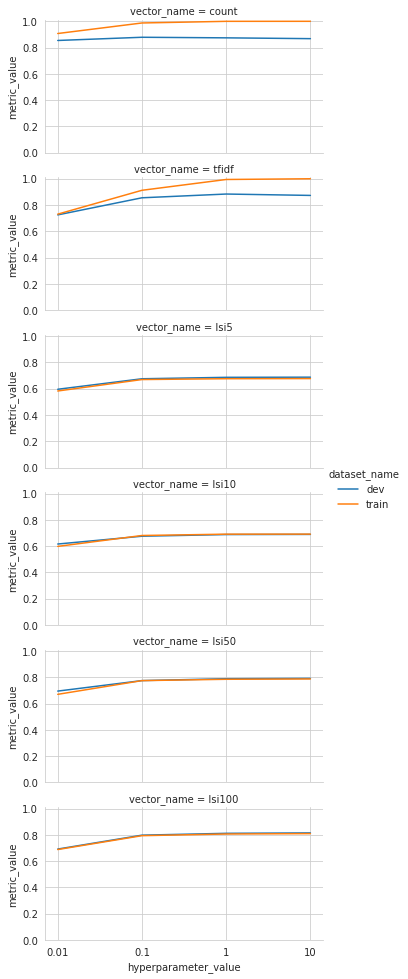

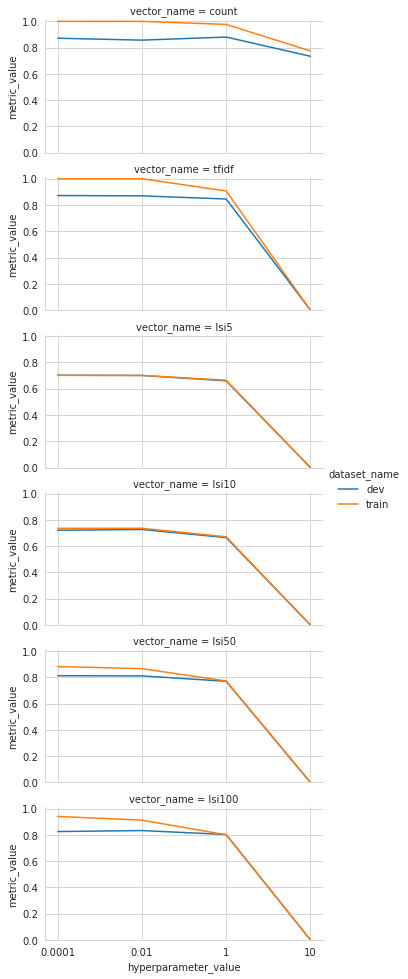

In [4]:
for model in ['decisiontree', 'svc', 'mlp']:
    visualize_model_metric(summary_df, 'binary_f1', model)
    
print()